In [68]:
import pandas as pd

df = pd.read_excel("finaldf_partner_imp_1k.xlsx", index_col=False)
df.drop(columns=["Column1","index_x","index_y","revenue_to_Revenue_ratio","symbol", "calendarYear", "marketCap", "Partner"], axis = 1, inplace = True)
df.head()

,Label,totalCurrentAssets_to_totalAssets_ratio,totalNonCurrentAssets_to_totalAssets_ratio,totalCurrentLiabilities_to_totalLiabilities_ratio,totalNonCurrentLiabilities_to_totalLiabilities_ratio,costOfRevenue_to_Revenue_ratio,grossProfit_to_Revenue_ratio,operatingExpenses_to_Revenue_ratio,ebitda_to_Revenue_ratio,acquisitionsNet_to_Revenue_ratio,investmentsInPropertyPlantAndEquipment_to_Revenue_ratio,commonStockIssued_to_Revenue_ratio,debtRepayment_to_Revenue_ratio,debtToEquity,debtToAssets,daysOfInventoryOnHand,workingCapital_to_revenue_Ratio,employee_revenue_ratio,Number of Product Segments,Number of Geo Segments
0,2,52.543267,47.456733,65.918286,34.081714,72.963421,27.036579,19.487096,7.270342,-76.344449,-2030.050116,0.669815,-1346.597918,0.469952,0.149550,80.392441,16.931293,0.000226,3,3
1,2,50.142358,49.857642,62.165864,37.834136,74.850994,25.149006,19.476318,15.567115,-149.646491,-1607.798758,2.513364,-993.654078,0.680004,0.202260,92.362922,15.423757,0.000234,3,3
2,2,47.520648,52.479352,68.611247,31.388753,75.073354,24.926646,17.734589,13.704331,-401.766840,-294.934587,166.070145,164.719169,0.720136,0.225146,96.741438,7.261509,0.000242,3,3
3,2,47.422916,52.577084,72.094450,27.905550,75.286739,24.713261,17.837664,12.844175,-427.229747,-354.411168,201.877065,200.226144,0.447787,0.177048,73.346435,7.006217,0.000251,4,3
4,2,47.904926,52.095074,75.492625,24.507375,73.459118,26.540882,18.771963,12.410075,-790.702850,-636.935020,362.817037,359.850068,0.206887,0.096555,77.153320,10.813318,0.000259,4,3


In [69]:
df_top_10 = df[["grossProfit_to_Revenue_ratio", "ebitda_to_Revenue_ratio", 
                "commonStockIssued_to_Revenue_ratio","debtRepayment_to_Revenue_ratio", "employee_revenue_ratio","acquisitionsNet_to_Revenue_ratio", "Label"]]


In [70]:
def remove_outliers(df):
    
    
    # Keep only numeric columns for outlier removal
    df_numeric = df.select_dtypes(include=[float])

    # Calculate lower and upper quantiles
    lower_quantiles = df_numeric.quantile(0.01)
    upper_quantiles = df_numeric.quantile(0.99)
    means = df_numeric.mean()

    # Filter out the outliers
    for col in df_numeric.columns:
        df_numeric = df_numeric[(df_numeric[col] > lower_quantiles[col]) &
                                (df_numeric[col] < upper_quantiles[col]) &
                                (df_numeric[col] <= 500) &
                                (df_numeric[col] >= -500)]
    
    # Create a filtered DataFrame with the original non-numeric columns
    df_filtered = df.loc[df_numeric.index]
     
    return df_filtered
# Apply the function
filtered_df = remove_outliers(df_top_10)

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pylab as plt
import numpy as np

# Separate explanatory (X) and target (y) variables
X = filtered_df.copy()
y = X.pop("Label")
y = y - 1

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


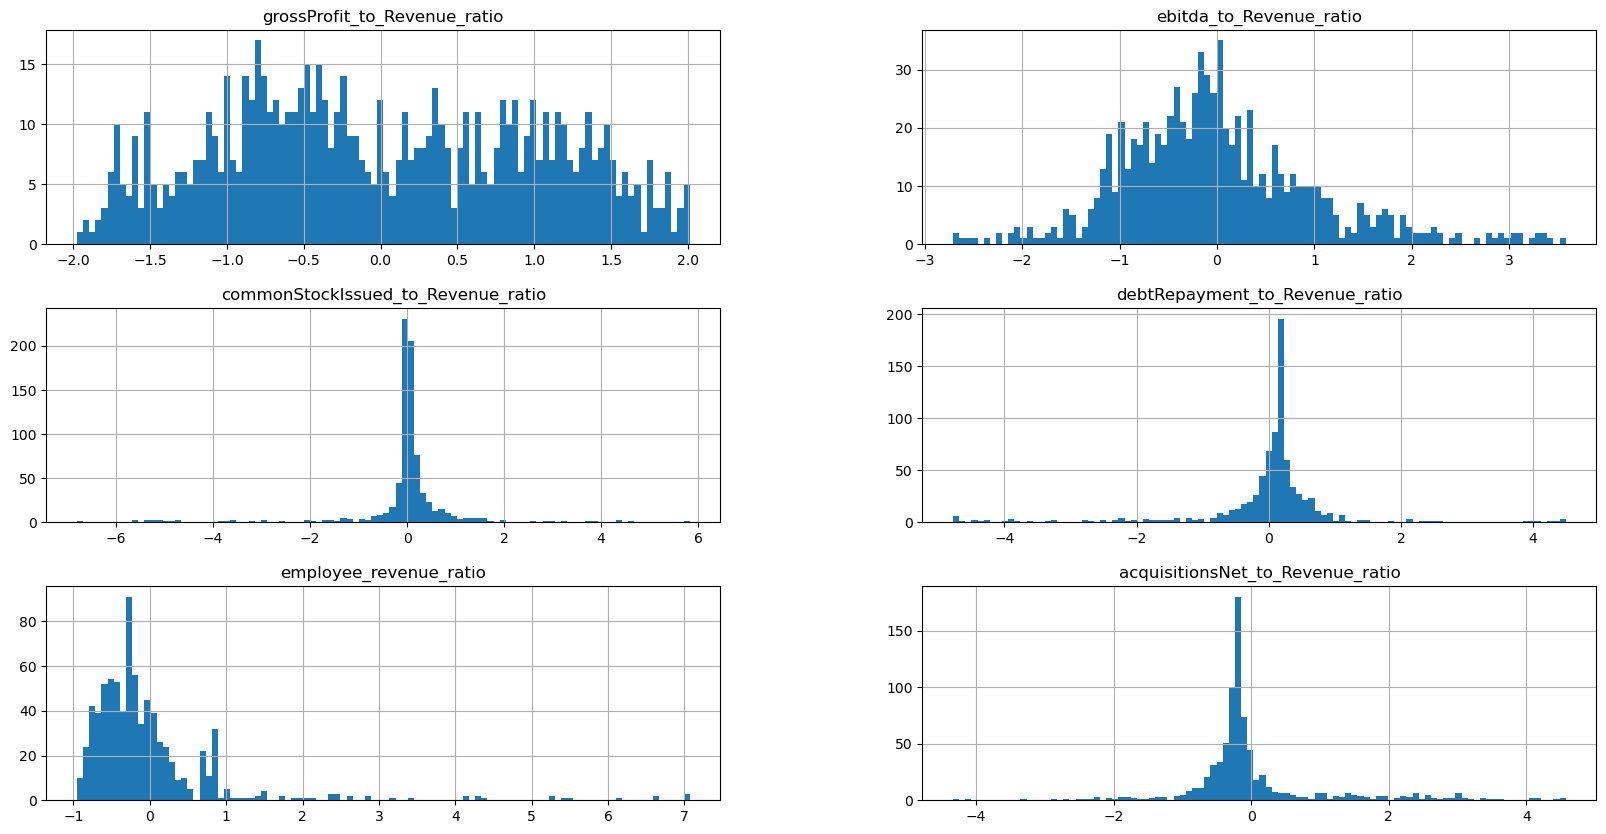

In [72]:
plt.rcParams["figure.figsize"] = (20, 10)
X_scaled_df.select_dtypes(exclude="bool").hist(bins=100)
plt.show()

In [73]:
from imblearn.over_sampling import SMOTE
import numpy as np 

oversampler = SMOTE()

X_resampled, y_resampled = oversampler.fit_resample(X_scaled_df,y)

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
import matplotlib.pylab as plt
import numpy as np



X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y)))


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3]
}

# Initialize GridSearchCV with the XGBoost model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Initialize the model with the best parameters
best_model = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y)), **best_params)

# Evaluate the best model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores with best parameters: {cv_scores}")
print(f"Mean CV accuracy with best parameters: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV accuracy with best parameters: {cv_scores.std():.4f}")

# Fit the best model on the training data
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = "mlogloss"
best_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.8}
Cross-validation scores with best parameters: [0.93181818 0.87878788 0.86363636 0.83333333 0.87878788]
Mean CV accuracy with best parameters: 0.8773
Standard Deviation of CV accuracy with best parameters: 0.0319


D:\Anaconda\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



              precision    recall  f1-score   support

           0       0.83      0.91      0.87        70
           1       0.97      0.81      0.88        80
           2       0.85      0.92      0.88        62
           3       0.85      0.86      0.86        72

    accuracy                           0.87       284
   macro avg       0.88      0.88      0.87       284
weighted avg       0.88      0.87      0.87       284



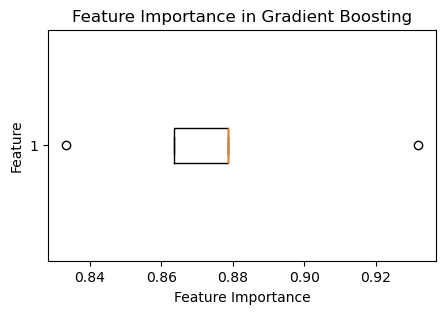

In [89]:
plt.figure(figsize=(5, 3))
plt.boxplot(cv_scores, vert = False)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Gradient Boosting")
plt.show()

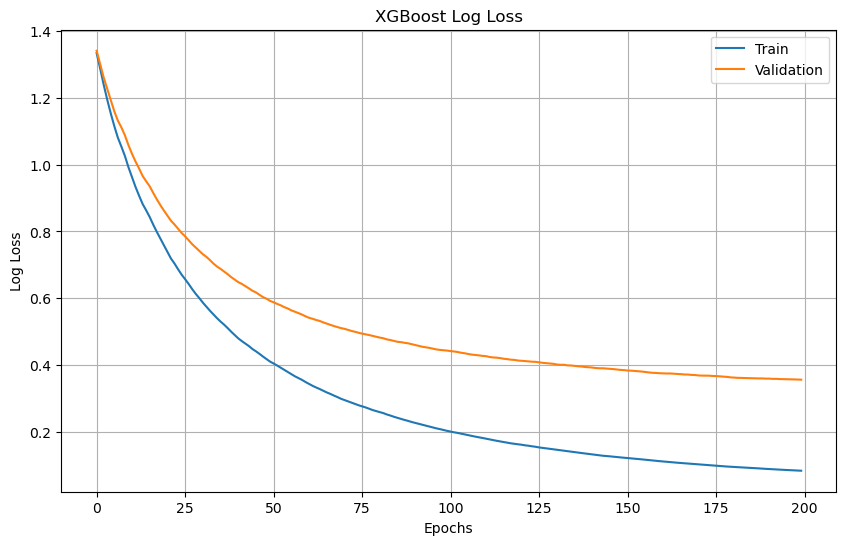

In [90]:
results = best_model.evals_result()

# Plot the learning curves
epochs = len(results['validation_0'][eval_metric])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0'][eval_metric], label='Train')
plt.plot(x_axis, results['validation_1'][eval_metric], label='Validation')
plt.title('XGBoost Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

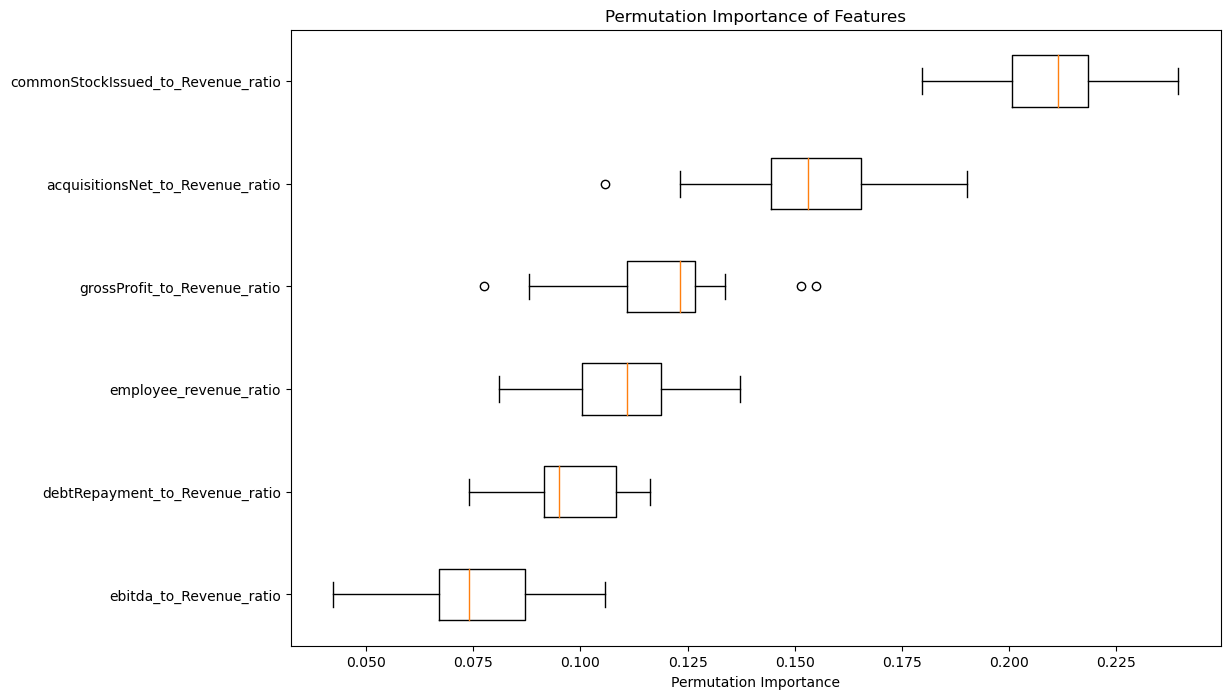

In [91]:
from sklearn.inspection import permutation_importance


result = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Extract the importances
importances = result.importances

# Get feature names
feature_names = X_train.columns

# Sort the features by the mean importance
sorted_indices = np.argsort(result.importances_mean)
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot permutation importances using boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(sorted_importances.T, vert=False, labels=sorted_feature_names)
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

In [92]:
import pandas as pd

df_full = pd.read_excel("S&P1500.xlsx")
df_full.drop(columns=["Unnamed: 0","index_x", "index_y", "revenue_to_Revenue_ratio", "marketCap"], axis = 1, inplace = True)
df_full

,Unnamed: 0.1,symbol,calendarYear,totalCurrentAssets_to_totalAssets_ratio,totalNonCurrentAssets_to_totalAssets_ratio,totalCurrentLiabilities_to_totalLiabilities_ratio,totalNonCurrentLiabilities_to_totalLiabilities_ratio,costOfRevenue_to_Revenue_ratio,grossProfit_to_Revenue_ratio,operatingExpenses_to_Revenue_ratio,...,investmentsInPropertyPlantAndEquipment_to_Revenue_ratio,commonStockIssued_to_Revenue_ratio,debtRepayment_to_Revenue_ratio,debtToEquity,debtToAssets,daysOfInventoryOnHand,workingCapital_to_revenue_Ratio,employee_revenue_ratio,Number of Product Segments,Number of Geo Segments
0,0,A,2007,48.596770,51.403230,38.495370,61.504630,45.221402,54.778598,44.003690,...,-1.935945,0.435263,-0.227376,0.687693,0.294414,95.754794,37.047970,0.000358,4.259274,1.604396
1,1,A,2008,43.135673,56.864327,27.162772,72.837228,44.648424,55.351576,41.582958,...,-1.935945,0.435263,-0.227376,0.908558,0.312626,91.462374,32.611708,0.000339,4.163378,1.697802
2,2,A,2009,52.036259,47.963741,21.993733,78.006267,48.850703,51.149297,50.100424,...,-1.935945,0.435263,-0.227376,1.236632,0.407120,92.042028,63.334077,0.000375,4.067482,1.791209
3,3,A,2010,63.967234,36.032766,47.724458,52.275542,46.179280,53.820720,43.423953,...,-1.935945,0.435263,-0.227376,1.162154,0.382725,103.953858,56.686260,0.000340,4.000000,1.884615
4,4,A,2011,61.576681,38.423319,38.747100,61.252900,46.651550,53.348450,37.157974,...,-1.935945,0.435263,-0.227376,0.507196,0.241250,106.211925,56.538171,0.000283,3.875691,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21755,22333,ZTS,2019,41.126029,58.873971,20.436800,79.563200,31.821086,68.178914,35.942492,...,-4.919260,0.074858,-0.096246,2.441285,0.572629,258.358434,42.392542,0.000169,5.000000,6.000000
21756,22334,ZTS,2020,48.578147,51.421853,22.061814,77.938186,30.816479,69.183521,35.191011,...,-5.310668,14.583822,-5.861665,1.953303,0.540966,288.877005,60.060588,0.000169,5.000000,6.000000
21757,22335,ZTS,2021,49.856115,50.143885,19.206926,80.793074,29.616770,70.383230,34.336420,...,-4.909428,1.846602,-6.216550,1.493286,0.488058,304.774208,180.168480,0.000156,5.000000,6.000000
21758,22336,ZTS,2022,50.291457,49.708543,30.098841,69.901159,30.371287,69.628713,33.391089,...,-5.033499,-0.991638,-11.510050,1.836549,0.542044,348.787694,135.509057,0.000171,5.000000,6.000000


In [93]:
df_full.dropna(how='any', inplace=True)
df_full.isnull().values.any()

False

In [94]:
df_full_top10 = df_full[["symbol","calendarYear","grossProfit_to_Revenue_ratio", "ebitda_to_Revenue_ratio", 
                "commonStockIssued_to_Revenue_ratio","debtRepayment_to_Revenue_ratio",
                 "employee_revenue_ratio","acquisitionsNet_to_Revenue_ratio"]]

In [95]:
def remove_outliers(df):
    # Separate the symbol column
    symbols = df['symbol']
    calendarYear = df['calendarYear']
    
    # Keep only numeric columns for outlier removal
    df_numeric = df.select_dtypes(include=[float])

    # Calculate lower and upper quantiles
    lower_quantiles = df_numeric.quantile(0.01)
    upper_quantiles = df_numeric.quantile(0.99)

    # Filter out the outliers
    for col in df_numeric.columns:
        df_numeric = df_numeric[(df_numeric[col] > lower_quantiles[col]) &
                                (df_numeric[col] < upper_quantiles[col]) &
                                (df_numeric[col] <= 500) &
                                (df_numeric[col] >= -500)]
    
    # Create a filtered DataFrame with the original non-numeric columns
    df_filtered = df.loc[df_numeric.index]
    
    return df_filtered
# Apply the function
filtered_df_full = remove_outliers(df_full_top10)


In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pylab as plt
import numpy as np


y_full = filtered_df_full[["symbol", "calendarYear"]]
X_full = filtered_df_full.drop(columns=["symbol", "calendarYear"])

# scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

X_scaled_full = pd.DataFrame(X_scaled, columns=X_full.columns)

In [97]:
import pandas as pd

predicted_labels =  best_model.predict(X_scaled_full)
predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Predicted Labels'])

In [98]:
y_full = y_full.reset_index()
y_full.drop(columns=["index"], axis = 1, inplace = True)
predicted_labels = pd.DataFrame(predicted_labels)
final_df = pd.concat([y_full, X_scaled_full, predicted_labels], axis=1)
final_df = final_df.rename(columns={0: "Predicted Labels"})
final_df["Predicted Labels"].value_counts()

0    5979
1    5950
3    3311
2    2377
Name: Predicted Labels, dtype: int64

In [99]:
transition_companies = final_df.groupby('symbol').filter(
    lambda x: (1 in x['Predicted Labels'].values) and (4 in x['Predicted Labels'].values)
)

transition_companies.symbol.unique()
transition_symbols = transition_companies['symbol'].unique()

In [106]:
transition_companies = final_df.groupby('symbol').filter(
    lambda x: (1 in x['Predicted Labels'].values) and (4 in x['Predicted Labels'].values)
)

# Get unique symbols that meet the transition criteria
transition_symbols = transition_companies['symbol'].unique()

# Create a figure
fig = go.Figure()

# Add traces for each company
for symbol in transition_symbols:
    company_data = transition_companies[transition_companies['symbol'] == symbol]
    fig.add_trace(go.Scatter(
        x=company_data['Calendar Year'],
        y=company_data['Predicted Labels'],
        mode='lines+markers',
        name=symbol,
        visible=True
    ))

# Create buttons for each company to update visibility
buttons = []
buttons.append(dict(
    label='All',
    method='update',
    args=[{'visible': [True] * len(transition_symbols)}, {'title': 'All Companies'}]
))

for symbol in transition_symbols:
    buttons.append(dict(
        label=symbol,
        method='update',
        args=[{'visible': [symbol == s for s in transition_symbols]},
              {'title': f'Company: {symbol}'}]
    ))

# Update layout to include buttons
fig.update_layout(
    title='Company Label Transitions from 1 to 4 Over Time',
    xaxis_title='Calendar Year',
    yaxis_title='Predicted Labels',
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1.15,
        'xanchor': 'right',
        'y': 1.15,
        'yanchor': 'top'
    }]
)

# Show the plot
fig.show()

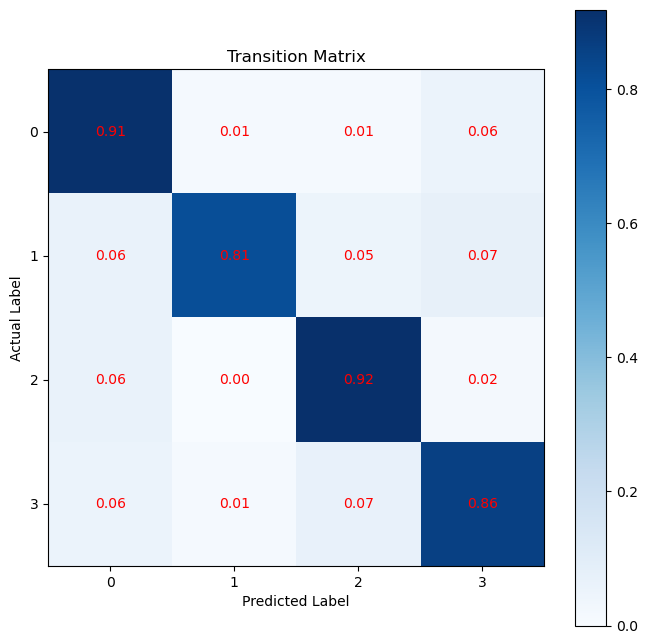

In [104]:
n_labels = len(np.unique(y_test))
transition_matrix = np.zeros((n_labels, n_labels))

for (actual, predicted) in zip(y_test, y_pred):
    transition_matrix[actual, predicted] += 1

# Normalize the transition matrix to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Plot the transition matrix
plt.figure(figsize=(8, 8))
plt.imshow(transition_matrix, cmap='Blues', interpolation='nearest')
plt.title('Transition Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.colorbar()

# Add labels to the plot
for i in range(n_labels):
    for j in range(n_labels):
        plt.text(j, i, f'{transition_matrix[i, j]:.2f}', ha='center', va='center', color='red')

plt.xticks(ticks=np.arange(n_labels), labels=np.arange(n_labels))
plt.yticks(ticks=np.arange(n_labels), labels=np.arange(n_labels))
plt.show()

In [105]:
final_df

,symbol,calendarYear,grossProfit_to_Revenue_ratio,ebitda_to_Revenue_ratio,commonStockIssued_to_Revenue_ratio,debtRepayment_to_Revenue_ratio,employee_revenue_ratio,acquisitionsNet_to_Revenue_ratio,Predicted Labels
0,A,2007,0.520720,-0.273751,-0.282443,0.379725,0.230746,0.095021,1
1,A,2008,0.544650,-0.167934,-0.282443,0.379725,0.172808,0.095021,1
2,A,2009,0.369147,-0.646751,-0.282443,0.379725,0.283988,0.095021,1
3,A,2010,0.480716,-0.262513,-0.282443,0.379725,0.173971,0.095021,1
4,A,2011,0.460992,-0.021314,-0.282443,0.379725,-0.005143,0.095021,1
...,...,...,...,...,...,...,...,...,...
17612,ZTS,2019,1.080366,0.624284,-0.289034,0.381480,-0.360536,0.058725,0
17613,ZTS,2020,1.122322,0.844884,-0.023687,0.304297,-0.360664,0.072005,0
17614,ZTS,2021,1.172426,0.702990,-0.256632,0.299546,-0.403555,0.092619,0
17615,ZTS,2022,1.140914,0.707142,-0.308539,0.228681,-0.355949,0.048343,0
